In [1]:
import torch, torchvision
import torch.nn.functional as F
from torch.optim import SGD,Adam,AdamW
from torch.utils.data import DataLoader
from torchcontrib.optim import SWA
from torch import optim

from oil.datasetup.datasets import split_dataset
from oil.utils.utils import Eval, LoaderTo, cosLr, dmap, FixedNumpySeed, FixedPytorchSeed

from flow_ssl.realnvp import RealNVPTabular
from flow_ssl.data.nlp_datasets import AG_News,YAHOO

from utils import swa_learning_rate
from swag.utils import calibration_curve
from models import RealNVPTabularWPrior, RealNVPTabularSWAG, SemiFlow, SemiFlowSWAG
from flowgmm_trainer import make_trainer
from ensembles import SWAG_Results, Ensembles
from swag.posteriors import SWAG
from temperature_scaling import ModelWithTemperature, EnsemblesWithTemperature

import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
from functools import partial

import warnings

## AG News

In [2]:
dataset = AG_News
train_data, test_data = dataset(), dataset(train=False) 

num_models = 3
num_epochs = 100
lr=3e-4

trainers=[
    make_trainer(
        train_data=train_data,
        test_data=test_data,
        split={'train':200,'val':100},
        network=RealNVPTabularWPrior,
        net_config={'k':1024,'coupling_layers':7,'nperlayer':1},
        num_epochs=num_epochs,
        optim=AdamW,
        lr=lr,
        trainer=SemiFlow,
        trainer_config={
            'unlab_weight':.6, 
#             'log_dir':os.path.expanduser('/scratch/pvn2005/flowgmm/base_checkpoints/model-{}'.format(index)), 
            'log_args':{'minPeriod':2, 'timeFrac':3/10}
        },
        dev='cuda'
    ) for i in range(num_models)
]

ensembles = Ensembles(trainers)

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    
    for trainer in trainers:
        trainer.train(num_epochs)
        
    ensembles.update_results(num_epochs, calibration=False)

Pairwise dists: [[ 0.         20.78723364 22.07247019 21.08715665]
 [20.78723364  0.         21.33838836 21.11959413]
 [22.07247019 21.33838836  0.         21.76490706]
 [21.08715665 21.11959413 21.76490706  0.        ]]
Pairwise dists: [[ 0.         21.82665081 22.35967243 21.9623018 ]
 [21.82665081  0.         20.99259518 21.39768661]
 [22.35967243 20.99259518  0.         21.70487509]
 [21.9623018  21.39768661 21.70487509  0.        ]]
Pairwise dists: [[ 0.         21.99377488 21.73211953 21.91427777]
 [21.99377488  0.         21.87697992 22.0082949 ]
 [21.73211953 21.87697992  0.         21.32074802]
 [21.91427777 22.0082949  21.32074802  0.        ]]


   Minibatch_Loss  Train_Acc  Unlab_loss(mb)     lr0  test_Acc  val_Acc  \
0     1725.557007      0.215     1070.052368  0.0003  0.293026     0.31   

    val_bpd  
0  10.01172  
     Minibatch_Loss  Train_Acc  Unlab_loss(mb)       lr0  test_Acc  val_Acc  \
416    -2045.036865        1.0    -1244.746582  0.000278  0.799211     0.83   

      val_bpd  
416  5.639765  
     Minibatch_Loss  Train_Acc  Unlab_loss(mb)      lr0  test_Acc  val_Acc  \
831    -2370.348633        1.0    -1360.208252  0.00022  0.823947     0.85   

      val_bpd  
831  5.408211  
      Minibatch_Loss  Train_Acc  Unlab_loss(mb)       lr0  test_Acc  val_Acc  \
1246    -2565.509033        1.0    -1411.792603  0.000141  0.831447     0.86   

       val_bpd  
1246  5.313637  
      Minibatch_Loss  Train_Acc  Unlab_loss(mb)       lr0  test_Acc  val_Acc  \
1660     -2680.23877        1.0    -1452.056519  0.000065  0.833553     0.87   

       val_bpd  
1660  5.232936  
      Minibatch_Loss  Train_Acc  Unlab_loss(mb)    

   Minibatch_Loss  Train_Acc  Unlab_loss(mb)     lr0  test_Acc  val_Acc  \
0     1734.042236       0.21     1075.609741  0.0003  0.250395     0.34   

     val_bpd  
0  10.022218  
     Minibatch_Loss  Train_Acc  Unlab_loss(mb)       lr0  test_Acc  val_Acc  \
415    -2048.745605        1.0    -1250.354126  0.000279  0.802895     0.82   

      val_bpd  
415  5.626686  
     Minibatch_Loss  Train_Acc  Unlab_loss(mb)      lr0  test_Acc  val_Acc  \
830    -2352.468262        1.0    -1348.442993  0.00022  0.815526     0.81   

      val_bpd  
830  5.432338  
      Minibatch_Loss  Train_Acc  Unlab_loss(mb)       lr0  test_Acc  val_Acc  \
1244    -2553.921631        1.0    -1409.172119  0.000142  0.826974     0.83   

      val_bpd  
1244  5.30414  
      Minibatch_Loss  Train_Acc  Unlab_loss(mb)       lr0  test_Acc  val_Acc  \
1657     -2671.78418        1.0    -1451.391968  0.000066  0.831711     0.86   

      val_bpd  
1657  5.23625  
      Minibatch_Loss  Train_Acc  Unlab_loss(mb)      

   Minibatch_Loss  Train_Acc  Unlab_loss(mb)     lr0  test_Acc  val_Acc  \
0     1725.958496      0.265     1073.359131  0.0003  0.229605     0.24   

     val_bpd  
0  10.018716  
     Minibatch_Loss  Train_Acc  Unlab_loss(mb)       lr0  test_Acc  val_Acc  \
413    -2039.588501        1.0    -1247.804565  0.000279  0.807763     0.85   

      val_bpd  
413  5.626038  
     Minibatch_Loss  Train_Acc  Unlab_loss(mb)       lr0  test_Acc  val_Acc  \
826    -2356.523193        1.0    -1356.484497  0.000221  0.819605     0.87   

      val_bpd  
826  5.418491  
      Minibatch_Loss  Train_Acc  Unlab_loss(mb)       lr0  test_Acc  val_Acc  \
1239    -2538.674561        1.0    -1408.483887  0.000143  0.827237     0.87   

       val_bpd  
1239  5.317639  
      Minibatch_Loss  Train_Acc  Unlab_loss(mb)       lr0  test_Acc  val_Acc  \
1652    -2656.561279        1.0    -1440.270508  0.000067  0.827763     0.85   

      val_bpd  
1652  5.25101  
      Minibatch_Loss  Train_Acc  Unlab_loss(mb)  

In [3]:
results = ensembles.results
num_models = results['Number of models']
for i in range(num_models):
    print("Test accuracy of model {}: {}".format(i+1, results['Model {}'.format(i+1)][-1]))
print("Test accuracy of Deep Ensembles model: {}".format(results['Deep Ensembles-{}'.format(num_models)][-1]))
print("Test accuracy of Flow Ensembles model: {}".format(results['Flow Ensembles-{}'.format(num_models)][-1]))

Test accuracy of model 1: 0.8357894736842105
Test accuracy of model 2: 0.8322368421052632
Test accuracy of model 3: 0.8272368421052632
Test accuracy of Deep Ensembles model: 0.8373684210526315
Test accuracy of Flow Ensembles model: 0.8398684210526316


### Temperature scaling

In [4]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    
    scaled_models = [ModelWithTemperature(trainer) for trainer in trainers]
    
    for index, model in enumerate(scaled_models):
        print("Model {}".format(index+1))
        model.set_temperature()
    print("Flow Ensembles")
    flow_scaled_model = EnsemblesWithTemperature(trainers)
    flow_scaled_model.set_temperature()

Model 1
Validation - Before temperature - NLL: 4.405, ECE: 0.144
Optimal temperature: 10.545
Validation - After temperature - NLL: 0.487, ECE: 0.108
Test - Before temperature - NLL: 8.044, ECE: 0.159
Test - After temperature - NLL: 0.830, ECE: 0.110
Model 2
Validation - Before temperature - NLL: 6.117, ECE: 0.142
Optimal temperature: 12.645
Validation - After temperature - NLL: 0.555, ECE: 0.131
Test - Before temperature - NLL: 8.160, ECE: 0.163
Test - After temperature - NLL: 0.725, ECE: 0.103
Model 3
Validation - Before temperature - NLL: 5.154, ECE: 0.158
Optimal temperature: 11.498
Validation - After temperature - NLL: 0.519, ECE: 0.124
Test - Before temperature - NLL: 8.228, ECE: 0.169
Test - After temperature - NLL: 0.788, ECE: 0.114
Flow Ensembles
Validation - Before temperature - NLL: 4.441, ECE: 0.140
Optimal temperature: 10.581
Validation - After temperature - NLL: 0.493, ECE: 0.107
Test - Before temperature - NLL: 7.651, ECE: 0.156
Test - After temperature - NLL: 0.788, ECE:

### Calibration

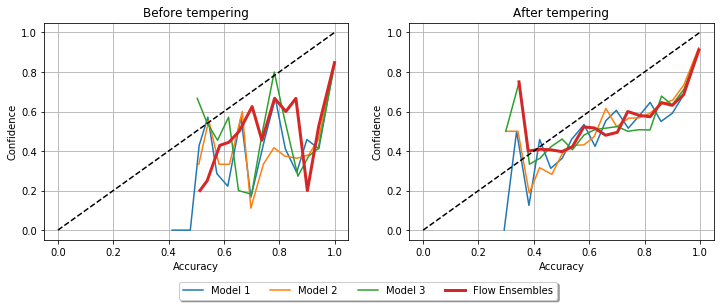

In [5]:
fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(12, 4))
for index, model in enumerate(scaled_models):
    calibration_dict = model.out_before
    ax1.plot(calibration_dict["confidence"], calibration_dict["accuracy"], 
     label="Model {}".format(index+1), color='C{}'.format(index))
#     print(calibration_dict["ece"].item())
    
for index, model in enumerate(scaled_models):
    calibration_dict = model.out_after
    ax2.plot(calibration_dict["confidence"], calibration_dict["accuracy"], 
     label="Model {}".format(index+1), color='C{}'.format(index))
#     print(calibration_dict["ece"].item())

calibration_dict = flow_scaled_model.out_before
ax1.plot(calibration_dict["confidence"], calibration_dict["accuracy"], 
 label="Flow Ensembles", lw=3, markersize=12, color='C3')

calibration_dict = flow_scaled_model.out_after
ax2.plot(calibration_dict["confidence"], calibration_dict["accuracy"], 
 label="Flow Ensembles", lw=3, markersize=12, color='C3')

# print(calibration_dict["ece"].item())
ax1.set(xlabel='Accuracy', ylabel='Confidence', title="Before tempering")
ax1.plot([0, 1], [0, 1], "--k")
ax2.set(xlabel='Accuracy', ylabel='Confidence', title="After tempering")
ax2.plot([0, 1], [0, 1], "--k")

ax1.grid()
ax2.grid()
plt.legend( loc = 'lower center', bbox_to_anchor = (0,-0.1,1,1),
            bbox_transform = plt.gcf().transFigure,fancybox=True, shadow=True, ncol=5 )
plt.show()

## YAHOO Answers

In [2]:
# dataset = AG_News
dataset = YAHOO
train_data, test_data = dataset(), dataset(train=False) 

num_models = 3
num_epochs = 200
lr=3e-4

trainers=[
    make_trainer(
        train_data=train_data,
        test_data=test_data,
        split={'train':800,'val':400},
        network=RealNVPTabularWPrior,
        net_config={'k':1024,'coupling_layers':7,'nperlayer':1},
        num_epochs=num_epochs,
        optim=AdamW,
        lr=lr,
        trainer=SemiFlow,
        trainer_config={
            'unlab_weight':.2, 
#             'log_dir':os.path.expanduser('/scratch/pvn2005/flowgmm/base_checkpoints/model-{}'.format(index)), 
            'log_args':{'minPeriod':3, 'timeFrac':3/10}
        },
        dev='cuda'
    ) for i in range(num_models)
]

ensembles = Ensembles(trainers)

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    
    for trainer in trainers:
        trainer.train(num_epochs)
        
    ensembles.update_results(num_epochs, calibration=False)

Pairwise dists: [[ 0.         21.87946692 21.57822818 21.53621727 21.78162038 20.98020705
  22.03446352 21.41787598 22.05038758 22.25923506]
 [21.87946692  0.         22.29210568 21.01418773 22.26998251 22.33179846
  23.27372437 22.35857659 21.92619774 22.48885399]
 [21.57822818 22.29210568  0.         21.57222245 21.93675599 22.63092873
  22.84801164 21.50473782 22.31123418 22.0702009 ]
 [21.53621727 21.01418773 21.57222245  0.         21.16371044 21.73227278
  22.40948853 21.10876621 22.425332   21.75303044]
 [21.78162038 22.26998251 21.93675599 21.16371044  0.         21.68197483
  22.26760914 22.04874428 22.43841644 23.06056195]
 [20.98020705 22.33179846 22.63092873 21.73227278 21.68197483  0.
  22.43043492 22.20544087 22.32893882 22.47372575]
 [22.03446352 23.27372437 22.84801164 22.40948853 22.26760914 22.43043492
   0.         22.43283004 23.01895995 22.81733895]
 [21.41787598 22.35857659 21.50473782 21.10876621 22.04874428 22.20544087
  22.43283004  0.         23.04875629 22.04

   Minibatch_Loss  Train_Acc  Unlab_loss(mb)     lr0  test_Acc  val_Acc  \
0     1297.450806    0.10125     1071.140381  0.0003    0.0981   0.0925   

     val_bpd  
0  10.010643  
     Minibatch_Loss  Train_Acc  Unlab_loss(mb)       lr0  test_Acc  val_Acc  \
433    -1572.482788    0.90625    -1324.167725  0.000267    0.5685    0.585   

      val_bpd  
433  5.490456  
     Minibatch_Loss  Train_Acc  Unlab_loss(mb)       lr0  test_Acc  val_Acc  \
862    -1803.943481    0.99875    -1454.167603  0.000182    0.5771    0.575   

     val_bpd  
862    5.258  
      Minibatch_Loss  Train_Acc  Unlab_loss(mb)       lr0  test_Acc  val_Acc  \
1291    -1919.500854        1.0    -1502.178223  0.000084    0.5814   0.5825   

       val_bpd  
1291  5.159615  
      Minibatch_Loss  Train_Acc  Unlab_loss(mb)       lr0  test_Acc  val_Acc  \
1721    -1978.165771        1.0     -1529.67395  0.000014    0.5806    0.585   

       val_bpd  
1721  5.108279  

      Minibatch_Loss  Train_Acc  Unlab_loss(mb) 

   Minibatch_Loss  Train_Acc  Unlab_loss(mb)     lr0  test_Acc  val_Acc  \
0     1296.331177      0.095     1071.373779  0.0003    0.0862   0.0925   

     val_bpd  
0  10.011248  
     Minibatch_Loss  Train_Acc  Unlab_loss(mb)       lr0  test_Acc  val_Acc  \
433    -1547.753296      0.905    -1303.313721  0.000267    0.5684   0.5875   

      val_bpd  
433  5.529615  
     Minibatch_Loss  Train_Acc  Unlab_loss(mb)       lr0  test_Acc  val_Acc  \
863    -1795.467529    0.99875    -1440.890991  0.000182    0.5773    0.585   

      val_bpd  
863  5.271207  
      Minibatch_Loss  Train_Acc  Unlab_loss(mb)       lr0  test_Acc  val_Acc  \
1293    -1924.592529        1.0    -1501.525635  0.000084    0.5794     0.62   

       val_bpd  
1293  5.158881  
      Minibatch_Loss  Train_Acc  Unlab_loss(mb)       lr0  test_Acc  val_Acc  \
1723    -1981.536255        1.0    -1523.437134  0.000014    0.5769   0.6175   

       val_bpd  
1723  5.118371  

      Minibatch_Loss  Train_Acc  Unlab_loss(mb

   Minibatch_Loss  Train_Acc  Unlab_loss(mb)     lr0  test_Acc  val_Acc  \
0     1294.700439     0.0975     1068.339233  0.0003    0.1009     0.09   

     val_bpd  
0  10.005205  
     Minibatch_Loss  Train_Acc  Unlab_loss(mb)       lr0  test_Acc  val_Acc  \
432    -1559.759644     0.9175    -1318.532715  0.000267    0.5587   0.5975   

      val_bpd  
432  5.511685  
     Minibatch_Loss  Train_Acc  Unlab_loss(mb)       lr0  test_Acc  val_Acc  \
861    -1804.325317     0.9975    -1452.553223  0.000183     0.575   0.5975   

      val_bpd  
861  5.253936  
      Minibatch_Loss  Train_Acc  Unlab_loss(mb)       lr0  test_Acc  val_Acc  \
1290    -1924.767822        1.0    -1506.831299  0.000084    0.5741    0.615   

       val_bpd  
1290  5.149766  
      Minibatch_Loss  Train_Acc  Unlab_loss(mb)       lr0  test_Acc  val_Acc  \
1719    -1975.963867        1.0    -1530.325073  0.000014    0.5762     0.62   

      val_bpd  
1719  5.10811  

      Minibatch_Loss  Train_Acc  Unlab_loss(mb) 

In [3]:
results = ensembles.results
num_models = results['Number of models']
for i in range(num_models):
    print("Test accuracy of model {}: {}".format(i+1, results['Model {}'.format(i+1)][-1]))
print("Test accuracy of Deep Ensembles model: {}".format(results['Deep Ensembles-{}'.format(num_models)][-1]))
print("Test accuracy of Flow Ensembles model: {}".format(results['Flow Ensembles-{}'.format(num_models)][-1]))

Test accuracy of model 1: 0.5809
Test accuracy of model 2: 0.5761
Test accuracy of model 3: 0.576
Test accuracy of Deep Ensembles model: 0.592
Test accuracy of Flow Ensembles model: 0.5972


### Temperature Scaling

In [4]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    
    scaled_models = [ModelWithTemperature(trainer) for trainer in trainers]
    
    for index, model in enumerate(scaled_models):
        print("Model {}".format(index+1))
        model.set_temperature()
    print("Flow Model")
    flow_scaled_model = EnsemblesWithTemperature(trainers)
    flow_scaled_model.set_temperature()

Model 1
Validation - Before temperature - NLL: 19.789, ECE: 0.406
Optimal temperature: 24.123
Validation - After temperature - NLL: 1.378, ECE: 0.091
Test - Before temperature - NLL: 19.056, ECE: 0.404
Test - After temperature - NLL: 1.387, ECE: 0.034
Model 2
Validation - Before temperature - NLL: 19.157, ECE: 0.369
Optimal temperature: 23.689
Validation - After temperature - NLL: 1.340, ECE: 0.082
Test - Before temperature - NLL: 19.574, ECE: 0.408
Test - After temperature - NLL: 1.410, ECE: 0.040
Model 3
Validation - Before temperature - NLL: 18.829, ECE: 0.376
Optimal temperature: 23.462
Validation - After temperature - NLL: 1.332, ECE: 0.077
Test - Before temperature - NLL: 19.247, ECE: 0.408
Test - After temperature - NLL: 1.403, ECE: 0.044
Flow Model
Validation - Before temperature - NLL: 17.553, ECE: 0.380
Optimal temperature: 22.540
Validation - After temperature - NLL: 1.287, ECE: 0.068
Test - Before temperature - NLL: 17.391, ECE: 0.388
Test - After temperature - NLL: 1.328, 

### Calibration

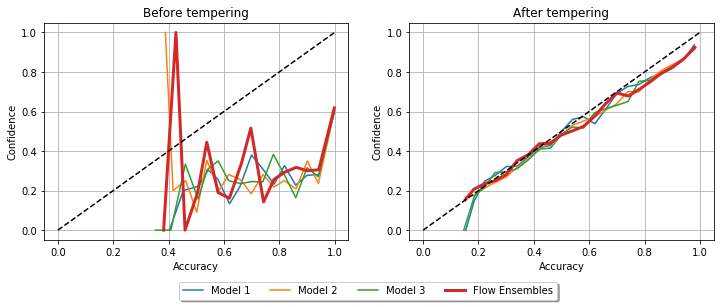

In [5]:
fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(12, 4))
for index, model in enumerate(scaled_models):
    calibration_dict = model.out_before
    ax1.plot(calibration_dict["confidence"], calibration_dict["accuracy"], 
     label="Model {}".format(index+1), color='C{}'.format(index))
#     print(calibration_dict["ece"].item())
    
for index, model in enumerate(scaled_models):
    calibration_dict = model.out_after
    ax2.plot(calibration_dict["confidence"], calibration_dict["accuracy"], 
     label="Model {}".format(index+1), color='C{}'.format(index))
#     print(calibration_dict["ece"].item())

calibration_dict = flow_scaled_model.out_before
ax1.plot(calibration_dict["confidence"], calibration_dict["accuracy"], 
 label="Flow Ensembles", lw=3, markersize=12, color='C3')

calibration_dict = flow_scaled_model.out_after
ax2.plot(calibration_dict["confidence"], calibration_dict["accuracy"], 
 label="Flow Ensembles", lw=3, markersize=12, color='C3')

# print(calibration_dict["ece"].item())
ax1.set(xlabel='Accuracy', ylabel='Confidence', title="Before tempering")
ax1.plot([0, 1], [0, 1], "--k")
ax2.set(xlabel='Accuracy', ylabel='Confidence', title="After tempering")
ax2.plot([0, 1], [0, 1], "--k")

ax1.grid()
ax2.grid()
plt.legend( loc = 'lower center', bbox_to_anchor = (0,-0.1,1,1),
            bbox_transform = plt.gcf().transFigure,fancybox=True, shadow=True, ncol=5 )
plt.show()

## Accuracy over epoch

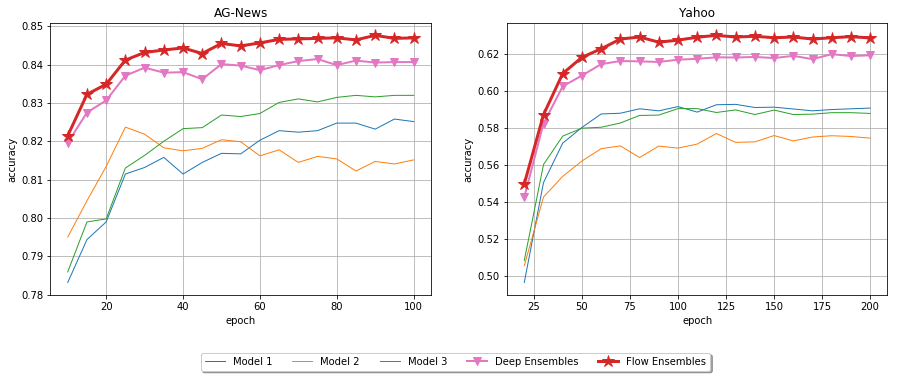

In [4]:
results_ag = Ensembles.load_results('results/AG_News-ensembles-002.json')
results_yahoo = Ensembles.load_results('results/YAHOO-ensembles-538.json')

fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(15, 5))
# fig, ax = plt.subplots(figsize=(8, 6))
Ensembles.plot_results(results_ag, ax1, 'AG-News', start=1)
Ensembles.plot_results(results_yahoo, ax2, 'Yahoo', start=1)

plt.legend( loc = 'lower center', bbox_to_anchor = (0,-0.1,1,1),
            bbox_transform = plt.gcf().transFigure,fancybox=True, shadow=True, ncol=5 )
plt.show()

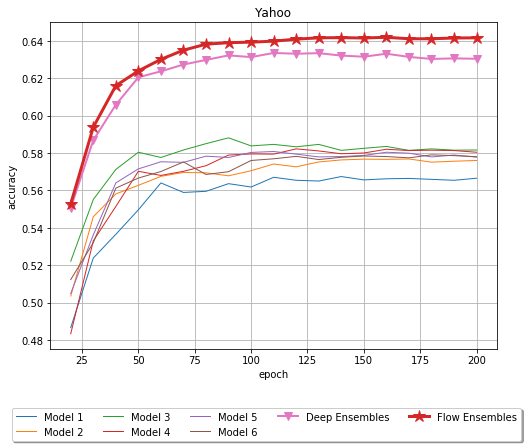

In [8]:
results_yahoo = Ensembles.load_results('results/YAHOO-ensembles-365.json')

fig, ax = plt.subplots(figsize=(8, 6))

Ensembles.plot_results(results_yahoo, ax, 'Yahoo', start=1)

plt.legend( loc = 'lower center', bbox_to_anchor = (0,-0.1,1,1),
            bbox_transform = plt.gcf().transFigure,fancybox=True, shadow=True, ncol=5 )
plt.show()